In [2]:
# Google Colab을 사용하는 경우 해당 셀을 실행하세요
import sys

if "google.colab" in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install --upgrade xgboost


import xgboost
import warnings

warnings.filterwarnings("ignore")
# xgboost.config.set_config(verbosity=0)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 3.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 KB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 KB 13.6 MB/s eta 0:00:00
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=2b660c494d694acb683351e65e8526989d4800a62037507ce0a994597673a599
  Stored in directory: /root/.cache/pip/wheels/85/ac/25/ffcd87ef8f9b1eec324fdf339359be71f22612459d8c75d89c
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the pac

0.28
0.41
0.29
0.23
0.73
0.65
0.42
                                                               3219
title                                                  Gisaengchung
year                                                           2019
certificate                                                       A
runtime                                                         132
genre                                               Drama, Thriller
rating                                                          8.5
metascore                                                      96.0
synopsis          Greed and class discrimination threaten the ne...
director                                               Bong Joon Ho
votes                                                        817099
gross                                                    53370000.0
cast1                                                  Song Kang-ho
cast2                                                  Lee Sun-kyun
cast3        

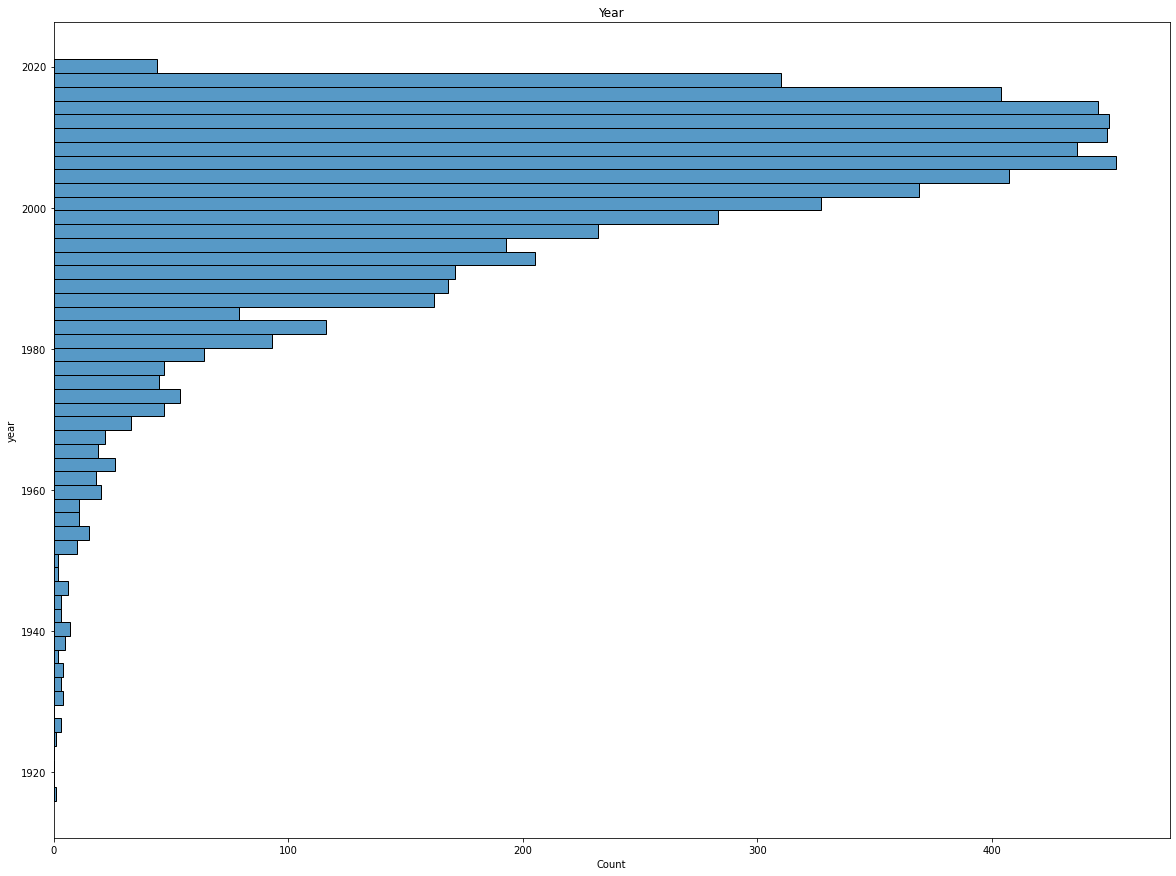

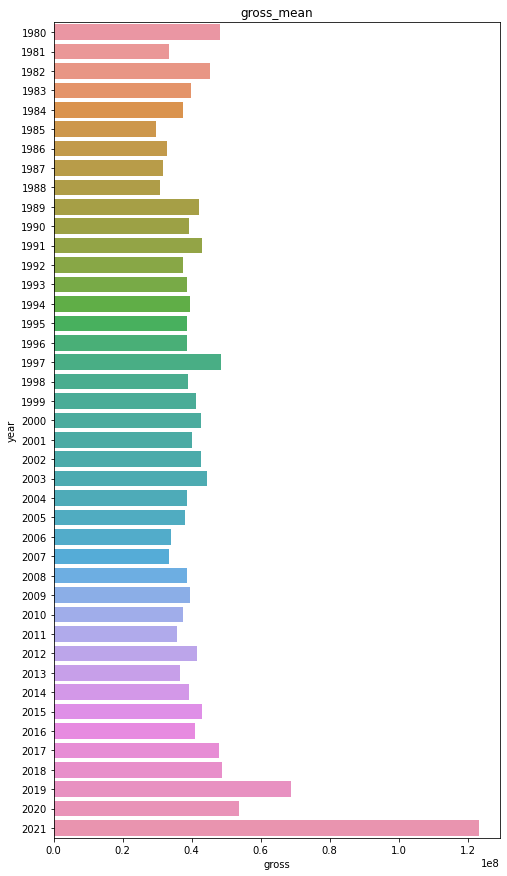

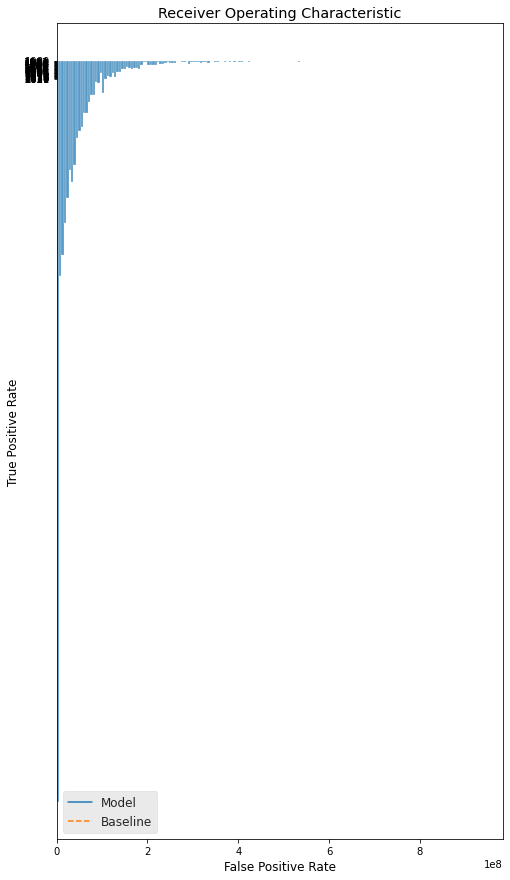

Test AUC: 0.5351344306248604
Top3 Important Features:
[('cast3', 0.030219892753407307), ('cast2', 0.015776979220972674), ('cast4', 0.011231566991882058)]


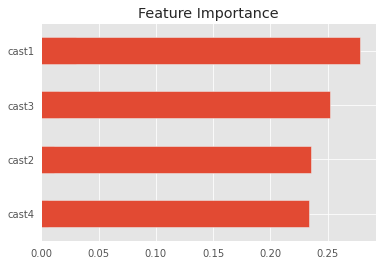

              precision    recall  f1-score   support

           0       0.54      0.57      0.56       464
           1       0.54      0.51      0.53       463

    accuracy                           0.54       927
   macro avg       0.54      0.54      0.54       927
weighted avg       0.54      0.54      0.54       927



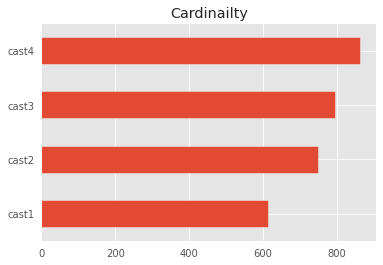

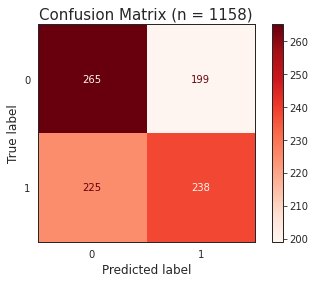

              precision    recall  f1-score   support

           0       0.51      0.64      0.57       579
           1       0.52      0.39      0.45       579

    accuracy                           0.52      1158
   macro avg       0.52      0.52      0.51      1158
weighted avg       0.52      0.52      0.51      1158



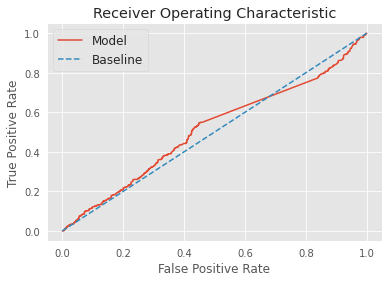

Test AUC: 0.5112814363398273


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from category_encoders import OrdinalEncoder
from scipy.stats.distributions import uniform
from sklearn.metrics import roc_curve, roc_auc_score
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.metrics import plot_confusion_matrix

df = pd.read_csv("/content/IMDB_Movies.csv")
df_original = df

# Part 1. EDA
df.isna().sum()
df.duplicated().sum()

df.runtime.fillna('100', inplace = True) # 전처리를 위해 임시로 결측치 대체(결측치 행이 3개라 큰 영향 없음)
df = df[df.runtime.isna() != True]
df = df[df.metascore.isna() != True]
df = df[df.gross.isna() != True]

# year, runtime, votes, gross 전처리(숫자열 변환)
import re
p1 = re.compile('\d+')
p2 = re.compile(',+')

for i in range(len(df)):
    year = p1.findall(df.iloc[i, 1]) # year
    df.iloc[i, 1] = year[0]
    
    runtime = p1.findall(df.iloc[i, 3]) # runtime
    df.iloc[i, 3] = runtime[0]
    
    df.iloc[i, -6] = p2.sub('', df.iloc[i,-6]) # votes
    
    df.iloc[i, -5] = df.iloc[i, -5].replace('$', '') # gross
    df.iloc[i, -5] = float(df.iloc[i, -5].replace('M', '')) * 1000000

df.year = df.year.astype('int')
df.runtime = df.runtime.astype('int')
df.votes = df.votes.astype('int')
df.gross = df.gross.astype('float')

year = pd.Series(df.year.unique())
year.sort_values()

# Animation 제외(실사영화배우 관점이므로)
df = df[~df.iloc[:, 4].str.contains("Animation")]

# year 분포 확인
plt.figure(figsize=(20,15))
sns.histplot(data=df, y="year").set(title='Year')

df = df[df.year >= 1980]

# votes, gross 분포 확인
gross_mean = df.groupby('year')['gross'].mean()
gross_median = df.groupby('year')['gross'].median()
votes_mean = df.groupby('year')['votes'].mean()
runtime_mean = df.groupby('year')['runtime'].mean()
gross_runtime = df.groupby('runtime')['gross'].mean()
rating_runtime = df.groupby('runtime')['rating'].mean()
metascore_runtime = df.groupby('runtime')['metascore'].mean()

gross_mean = pd.DataFrame(data=gross_mean)
gross_mean['year'] = gross_mean.index
votes_mean = pd.DataFrame(data=votes_mean)
votes_mean['year'] = votes_mean.index
gross_runtime = pd.DataFrame(data=gross_runtime)
gross_runtime['runtime'] = gross_runtime.index

rating_runtime = pd.DataFrame(data=rating_runtime)
rating_runtime['runtime'] = rating_runtime.index

metascore_runtime = pd.DataFrame(data=metascore_runtime)
metascore_runtime['runtime'] = metascore_runtime.index

# year, runtime, gross 상관관계 확인
df_check = df[['runtime', 'gross', 'rating', 'metascore']]
df_corr = np.corrcoef(df_check['runtime'], df_check['gross'])[0, 1]
print(round(df_corr, 2))

df_corr = np.corrcoef(df_check['runtime'], df_check['rating'])[0, 1]
print(round(df_corr, 2))

df_corr = np.corrcoef(df_check['runtime'], df_check['metascore'])[0, 1]
print(round(df_corr, 2))

gross_runtime_corr = np.corrcoef(gross_runtime['runtime'], gross_runtime['gross'])[0, 1]
print(round(gross_runtime_corr, 2))

rating_runtime_corr = np.corrcoef(rating_runtime['runtime'], rating_runtime['rating'])[0, 1]
print(round(rating_runtime_corr, 2))

metascore_runtime_corr = np.corrcoef(metascore_runtime['runtime'], metascore_runtime['metascore'])[0, 1]
print(round(metascore_runtime_corr, 2))

gross_year_corr = np.corrcoef(gross_mean['year'], gross_mean['gross'])[0, 1]
print(round(gross_year_corr, 2))

plt.figure(figsize = (8,15))
sns.barplot(x=gross_mean['gross'], y=gross_mean['year'], orient="h").set(title='gross_mean')

plt.figure(figsize = (8,15))
sns.barplot(x=votes_mean['votes'], y=votes_mean['year'], orient="h").set(title='votes_mean')

# 이상치 제거
df = df[df["gross"] != 0]
df.reset_index(drop=True, inplace=True)

# masterpiece rate 설정 (rating, metascore, gross 지표 통합)
df_mr = df[["rating", "metascore", "gross"]]

# 타겟 분포 시각화
sns.set_style("whitegrid")
sns.histplot(df_mr["rating"]).set(title='Rating Original')

sns.histplot(df_mr["metascore"]).set(title='Metascore Original')

sns.histplot(df_mr["gross"]).set(title='Gross Original')

gross_log_scaled = np.log1p(df_mr["gross"])

sns.histplot(gross_log_scaled).set(title='Gross log Scaled')

'''
# 저예산 영화 판별 (6e+06 or 1e+8)
df_gross = df_mr["gross"]
df_gross = pd.DataFrame(df_gross)
df_gross = df_gross.sort_values(by='gross')
df_gross.reset_index(drop=True, inplace=True)
df_gross = df_gross.iloc[1860:4250]

sns.histplot(df_gross).set(title='Gross')

sns.histplot(df.votes).set(title='votes')

df_check = df_gross[df_gross['gross'] >= 1e+8]
'''

'''
# 흥행 성공하면 투표수 대비 gross가 높고 실패하면 gross가 낮을 것이다.(가설)
df_mr['votes'] = df['votes']
df_mr['gross_per_votes'] = df['gross'] / df['votes']
sns.histplot(df_mr['gross_per_votes']).set(title='gross_per_votes')

df_gpv = df_mr[df_mr["gross_per_votes"] >= 100]
sns.histplot(df_gpv["gross_per_votes"]).set(title='gross_per_votes')
'''

# gross의 데이터 분포가 불균형하고 값의 차이가 커서 MinMaxScaler 는 적절하지 않음 -> 로그 스케일링
# 또는 RobustScaler로 스케일링(이상치 영향 최소화)

# rating, metascore, gross 스케일링 (MinMaxScaler, np.log1p)
df_mr["gross"] = np.log1p(df_mr['gross'])

minmax_scaler = MinMaxScaler().fit(df_mr)

df_minmax = minmax_scaler.transform(df_mr)

df_minmax = pd.DataFrame(df_minmax)

# 스케일링 된 타겟 분포 시각화
sns.histplot(df_minmax[0]).set(title='Rating Scaled', xlabel='rating')

sns.histplot(df_minmax[1]).set(title='Metascore Scaled', xlabel='metascore')

sns.histplot(df_minmax[2]).set(title='Gross Scaled', xlabel='gross')

df["masterpiece_rate"] = None

# rating과 metascore의 평균에 gross를 곱해서 masterpiece_rate 생성
for i in range(len(df)):
    df.iloc[i, -1] = (df_minmax.iloc[i, 0] + df_minmax.iloc[i, 1] + df_minmax.iloc[i, 2])

df["masterpiece_rate"] = df["masterpiece_rate"].astype('float')

# masterpiece_rate 분포 확인
sns.histplot(df["masterpiece_rate"]).set(title='Masterpiece Rate', xlabel='masterpiece_rate')

# 정규화
df_minmax[3] = df["masterpiece_rate"]
minmax_scaler = MinMaxScaler().fit(df_minmax)
df_minmax = minmax_scaler.transform(df_minmax)
df["masterpiece_rate"] = df_minmax[:, 3]

sns.histplot(df["masterpiece_rate"]).set(title='Masterpiece Rate', xlabel='masterpiece_rate')

# 샘플 확인
print(df[df["title"] == "Gisaengchung"].T) # 0.92, 53,370,000
print(df[df["title"] == "Avatar"].T) # 0.93, 760,510,000
print(df[df["title"] == "Star Wars: Episode IX - The Rise of Skywalker"].T) # 0.73, 515,200,000
print(df[df["title"] == "Whiplash"].T) # 0.84, 13,090,000
print(df[df["title"] == "Transformers"].T) # 0.77, 319,250,000
print(df[df["title"] == "Transformers: The Last Knight"].T) # 0.52, 130,170,000
print(df[df["title"] == "Justice League"].T) # 0.65, 229,020,000
print(df[df["title"] == "Iron Man"].T) # 0.88, 318,410,000
print(df[df["title"] == "Iron Man 2"].T) # 0.75, 312,430,000
print(df[df["title"] == "Iron Man Three"].T) # 0.79, 409,010,000
print(df[df["title"] == "Oldeuboi"].T) # 0.70, 710,000

# 타겟 설정
df["masterpiece"] = None

# masterpiece rate가 0.616726이상이면 masterpiece로 간주 (median = 0.616726)
for i in range(len(df)):
    if df.iloc[i, -2] >= 0.616726:
        df.iloc[i, -1] = 1
    
    else:
        df.iloc[i, -1] = 0

df["masterpiece"] = df["masterpiece"].astype('int')

df.drop(['title', 'year', 'runtime', 'certificate', 'director', 'genre',
         'synopsis', 'votes', 'rating', 'metascore', 'gross', 'masterpiece_rate'],
        axis=1, inplace=True)

target = 'masterpiece'
feature = df.columns.drop(target)

train, test = train_test_split(df, test_size=0.2, stratify=df[target], random_state=42)
train, val = train_test_split(train, test_size=0.2, stratify=train[target], random_state=42)
print(train.shape, val.shape, test.shape)

def divide_data(df):

    X = df[feature]
    y = df[target]
    
    return X, y

X_train, y_train = divide_data(train)
X_val, y_val = divide_data(val)
X_test, y_test = divide_data(test)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

# baseline score : 1로 예측했을 때의 accuracy
baseline = df[target].value_counts()
baseline_score = baseline[1] / baseline.sum()
print("Baseline Score:", baseline_score)

# Part 2. 모델 학습
def fit(X_train, y_train):
    pipeline = make_pipeline(
        OrdinalEncoder(),
        XGBClassifier(
            objective="binary:logistic",
            eval_metric="auc",
            random_state=42,
            n_jobs=-1,
            )
        )
    
    params = {
    "xgbclassifier__n_estimators" : [50, 100, 150, 200, 250],    
    "xgbclassifier__learning_rate" : [0.1, 0.2, 0.3],
    "xgbclassifier__max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    "xgbclassifier__min_child_weight": [1, 2, 4, 8, 16, 32, 64, 128],
    "xgbclassifier__colsample_bytree": uniform(
        loc=0.5, scale=0.5
        ),  # 0.5 ~ 1 사이의 uniform 분포로 범위를 지정해 줍니다.
    }
    
    clf = RandomizedSearchCV(
        pipeline,
        param_distributions=params,
        scoring="roc_auc",
        n_iter=10,
        cv=3,
        verbose=3,
        random_state=42,
        )
    
    clf.fit(X_train, y_train)
    print("Optimal Hyperparameter:", clf.best_params_)
    print("AUC:", clf.best_score_)

    return clf

def predict(X, y, best_estimator):

    y_pred_proba = best_estimator.predict_proba(X)[:, 1]

    report = classification_report(y, y_pred_proba > 0.5)
    return y_pred_proba, report

clf = fit(X_train, y_train)

def plot_roc(y, y_pred_proba):
    auc_score = roc_auc_score(y, y_pred_proba)
    fpr, tpr, _ = roc_curve(y, y_pred_proba)
    baseline_fpr, baseline_tpr, _ = roc_curve(y, [0] * len(y))

    plt.style.use("ggplot")
    plt.plot(fpr, tpr, label="Model")
    plt.plot(baseline_fpr, baseline_tpr, linestyle="--", label="Baseline")
    plt.xlabel("False Positive Rate", size=12)
    plt.ylabel("True Positive Rate", size=12)
    plt.title("Receiver Operating Characteristic")
    plt.legend(prop={"size": 12})
    plt.show()
    return auc_score

# ROC, f1 지표 사용(명작 지표를 상위 50%로 설정했기 때문에 성공이라고 예상한 영화가 실패하는 경우가 치명적이므로)
y_val_pred_proba, report = predict(X_val, y_val, clf.best_estimator_)
print(report)
auc_score = plot_roc(y_val, y_val_pred_proba)

print("Test AUC:", auc_score)

# Part 3. 시각화
pipeline = clf.best_estimator_

preprocess_pipeline = pipeline.named_steps['ordinalencoder']
model = pipeline.named_steps['xgbclassifier']

X_val_preprocessed = preprocess_pipeline.fit_transform(X_val)

def get_permutation_importance(X, y, model):

    permuter = PermutationImportance(
        model,  # model
        scoring="roc_auc",  # metric
        n_iter=5,  # 다른 random seed를 사용하여 10번 반복
        random_state=2,
        )
    
    permuter.fit(X, y)

    return permuter

permuter = get_permutation_importance(X_val_preprocessed, y_val, model)
eli5.show_weights(permuter, top=None, feature_names=X_val.columns.tolist())
print("Top3 Important Features:")
p_i = sorted(
    list(zip(X_val.columns.tolist(), permuter.feature_importances_)),
    key=lambda x: x[1],
    reverse=True,
)
print(p_i[:3])

feature_names = X_val.columns.tolist()
pi = pd.Series(permuter.feature_importances_, feature_names).sort_values()
pi.plot.barh()
plt.title("Permutation Importance")

# feature importance
importances = pd.Series(model.feature_importances_, X_val.columns)
importances.sort_values().plot.barh();
plt.title("Feature Importance")
plt.show()

X_val.nunique().sort_values().plot.barh()
plt.title("Cardinailty")

# confusion matrix
print(classification_report(y_val, clf.predict(X_val)))

sns.set_style("white")
plot_confusion_matrix(clf, X_val, y_val, cmap=plt.cm.Reds)
plt.title(f"Confusion Matrix (n = {len(y_test)})", fontsize=15)
plt.show()

# test score
y_test_pred_proba, report = predict(X_test, y_test, clf.best_estimator_)
print(report)
auc_score = plot_roc(y_test, y_test_pred_proba)

print("Test AUC:", auc_score)